In [2]:
!pip install pandas scikit-learn xgboost matplotlib seaborn

  Using cached pandas-2.3.0-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.7.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Using cached pillo


🎯 Entrenando RandomForest...

📊 Resultados para RandomForest:
✅ Accuracy en entrenamiento: 1.00
🧪 Accuracy en prueba:       1.00

Classification Report:
                precision    recall  f1-score   support

caminarEspalda       1.00      1.00      1.00        18
 caminarFrente       1.00      1.00      1.00        25
         girar       1.00      1.00      1.00        29
    levantarse       1.00      1.00      1.00        17
      sentarse       1.00      1.00      1.00        24

      accuracy                           1.00       113
     macro avg       1.00      1.00      1.00       113
  weighted avg       1.00      1.00      1.00       113



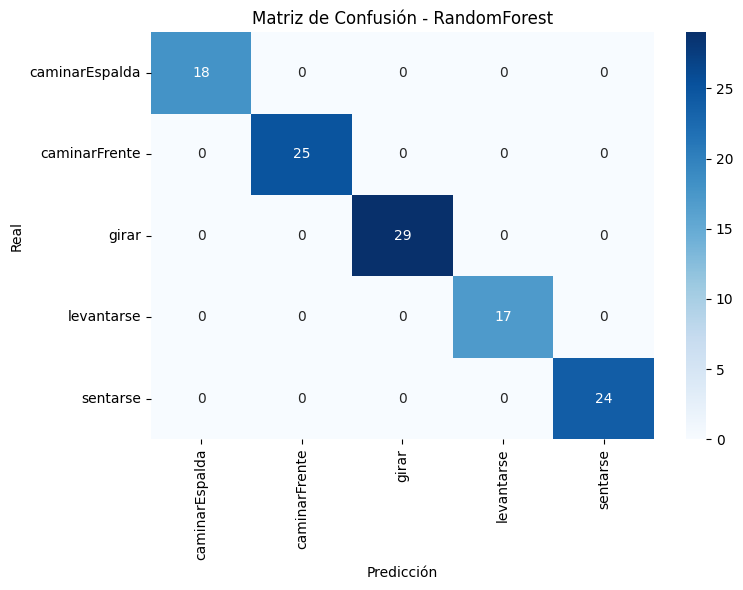


🎯 Entrenando SVM...

📊 Resultados para SVM:
✅ Accuracy en entrenamiento: 0.79
🧪 Accuracy en prueba:       0.77

Classification Report:
                precision    recall  f1-score   support

caminarEspalda       0.78      1.00      0.88        18
 caminarFrente       0.86      1.00      0.93        25
         girar       1.00      0.69      0.82        29
    levantarse       0.00      0.00      0.00        17
      sentarse       0.59      1.00      0.74        24

      accuracy                           0.77       113
     macro avg       0.65      0.74      0.67       113
  weighted avg       0.70      0.77      0.71       113



c:\Users\daron\OneDrive\Escritorio\Semestre VII\IA\Body_Recognition\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\daron\OneDrive\Escritorio\Semestre VII\IA\Body_Recognition\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\daron\OneDrive\Escritorio\Semestre VII\IA\Body_Recognition\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

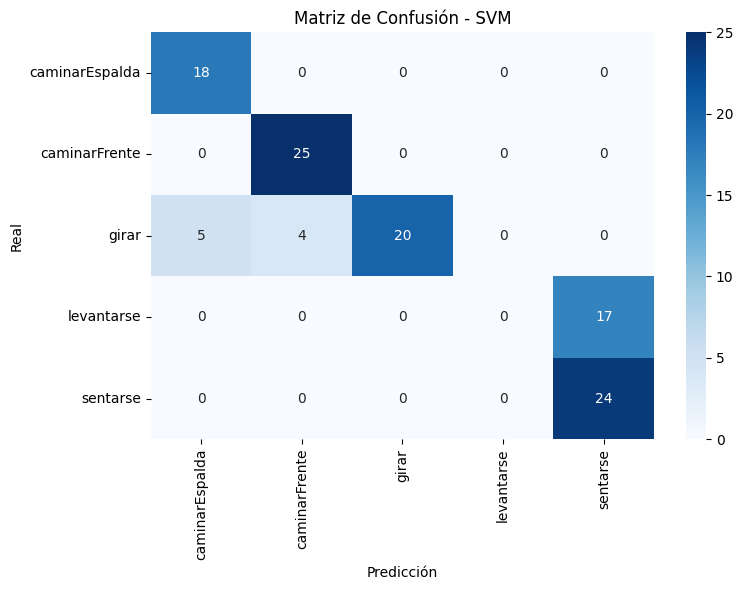


🎯 Entrenando XGBoost...


c:\Users\daron\OneDrive\Escritorio\Semestre VII\IA\Body_Recognition\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:17:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Resultados para XGBoost:
✅ Accuracy en entrenamiento: 1.00
🧪 Accuracy en prueba:       1.00

Classification Report:
                precision    recall  f1-score   support

caminarEspalda       1.00      1.00      1.00        18
 caminarFrente       1.00      1.00      1.00        25
         girar       1.00      1.00      1.00        29
    levantarse       1.00      1.00      1.00        17
      sentarse       1.00      1.00      1.00        24

      accuracy                           1.00       113
     macro avg       1.00      1.00      1.00       113
  weighted avg       1.00      1.00      1.00       113



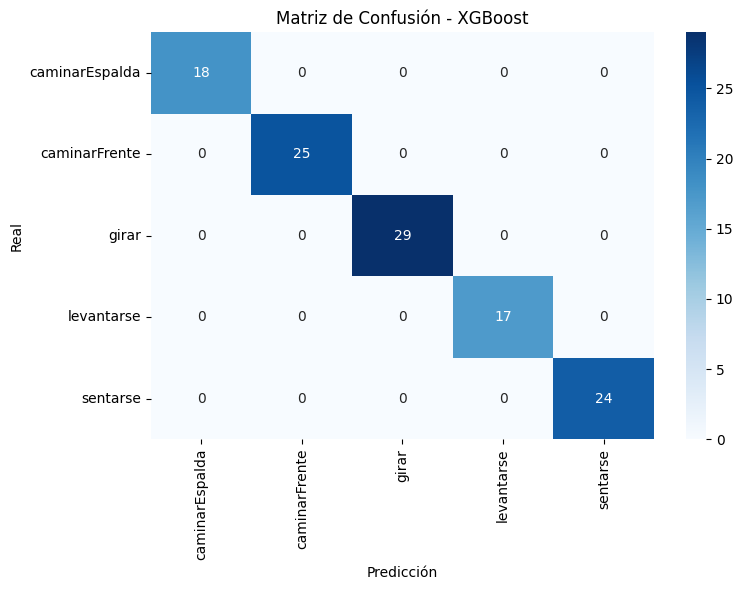

['label_encoder.pkl']

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import joblib

# Cargar el dataset
df = pd.read_csv("../data_set_videos/dataset_final.csv")

# Eliminamos las filas con demasiados ceros (por ejemplo, más del 30% de los valores)
umbral_ceros = 0.3  # puedes ajustarlo si es muy estricto o laxo
porcentaje_ceros = (df == 0).sum(axis=1) / df.shape[1]
df = df[porcentaje_ceros < umbral_ceros]

# Separar features y etiquetas
X = df.drop(columns=["label", "frame"])  # Eliminamos 'frame' y 'label'
y = df["label"]

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir en entrenamiento y prueba (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Modelos a evaluar
modelos = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Entrenamiento y evaluación
for nombre, modelo in modelos.items():
    print(f"\n🎯 Entrenando {nombre}...")
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)

    train_acc = modelo.score(X_train, y_train)
    test_acc = modelo.score(X_test, y_test)

    print(f"\n📊 Resultados para {nombre}:")
    print(f"✅ Accuracy en entrenamiento: {train_acc:.2f}")
    print(f"🧪 Accuracy en prueba:       {test_acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Matriz de confusión
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    #para guarda el modelo
    joblib.dump(modelo, f"modelo_{nombre}.pkl")

joblib.dump(le, "label_encoder.pkl")
